In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from pymc_marketing.mmm import GeometricAdstock, MichaelisMentenSaturation
from pymc_marketing.mmm.MultiDimensionalMMM import MMM

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [3]:
MMM

pymc_marketing.mmm.MultiDimensionalMMM.MMM

In [4]:
GeometricAdstock

pymc_marketing.mmm.components.adstock.GeometricAdstock

In [5]:
# Generate a date range
date_range = pd.date_range(start="2023-01-01", end="2023-01-10")

# Define countries and channels
countries = ["Venezuela", "Colombia", "Chile", "Argentina"]
channels = ["a", "b"]

# Create a DataFrame
data = []
for country in countries:
    for date in date_range:
        record = [date, country, *list(np.random.randint(100, 500, size=len(channels)))]
        data.append(record)

df = pd.DataFrame(data, columns=["date", "country", *channels])
df["target"] = df[channels].sum(axis=1) + np.random.randint(100, 500, size=len(df))
df.head()

,date,country,a,b,target
0,2023-01-01,Venezuela,368,182,1046
1,2023-01-02,Venezuela,100,259,579
2,2023-01-03,Venezuela,265,180,944
3,2023-01-04,Venezuela,454,446,1188
4,2023-01-05,Venezuela,346,118,773


In [6]:
from pymc_marketing.prior import Prior

# Strange error here.
hierarchical_alpha = Prior(
    "Gamma",
    mu=Prior("HalfNormal", sigma=1, dims="country"),
    sigma=Prior("HalfNormal", sigma=1, dims="country"),
    dims=("channel", "country"),
)
common_lam = Prior("HalfNormal", sigma=1, dims=("channel",))
priors = {
    "alpha": hierarchical_alpha,
    "lam": common_lam,
}

# Not working with hierarchical priors

In [7]:
# Strange error here.
hierarchical_alpha = Prior(
    "Gamma",
    mu=Prior("HalfNormal", sigma=1, dims="country"),
    sigma=Prior("HalfNormal", sigma=1, dims="country"),
    dims=("channel", "country"),
)
common_lam = Prior("HalfNormal", sigma=1, dims=("channel",))
priors = {
    "alpha": hierarchical_alpha,
    "lam": common_lam,
}

mmm = MMM(
    date_column="date",
    target_column="target",
    channel_columns=["a", "b"],
    dims=("country",),
    adstock=GeometricAdstock(l_max=2),
    saturation=MichaelisMentenSaturation(),
    yearly_seasonality=12,
    time_varying_media=True,
    time_varying_intercept=True,
)

In [8]:
mmm.build_model(X=df.drop(columns="target"), y=df.drop(columns=channels))

In [9]:
mmm.fit(
    X=df.drop(columns="target"),
    y=df.drop(columns=channels),
    chains=4,
    target_accept=0.85,
    nuts_sampler="numpyro",
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [10]:
import pytensor
from pymc.model.transform.optimization import freeze_dims_and_data
pytensor.dprint(freeze_dims_and_data(mmm.model)["y"], depth=8, print_type=True)

normal_rv{"(),()->()"}.1 [id A] <Matrix(float64, shape=(10, 4))> 'y'
 ├─ RNG(<Generator(PCG64) at 0x32FE78820>) [id B] <RandomGeneratorType>
 ├─ MakeVector{dtype='int64'} [id C] <Vector(int64, shape=(2,))>
 │  ├─ date{10} [id D] <Scalar(int64, shape=())>
 │  └─ country{4} [id E] <Scalar(int64, shape=())>
 ├─ Mul [id F] <Matrix(float64, shape=(10, 4))>
 │  ├─ Add [id G] <Matrix(float64, shape=(10, 4))>
 │  │  ├─ Add [id H] <Matrix(float64, shape=(10, 4))>
 │  │  │  ├─ Mul [id I] <Matrix(float64, shape=(10, 4))> 'intercept'
 │  │  │  │  ├─ ExpandDims{axis=0} [id J] <Matrix(float64, shape=(1, 4))>
 │  │  │  │  │  └─ normal_rv{"(),()->()"}.1 [id K] <Vector(float64, shape=(4,))> 'baseline_intercept'
 │  │  │  │  │     ├─ RNG(<Generator(PCG64) at 0x32FE78BA0>) [id L] <RandomGeneratorType>
 │  │  │  │  │     ├─ MakeVector{dtype='int64'} [id M] <Vector(int64, shape=(1,))>
 │  │  │  │  │     ├─ ExpandDims{axis=0} [id N] <Vector(int8, shape=(1,))>
 │  │  │  │  │     └─ ExpandDims{axis=0} [id O] 

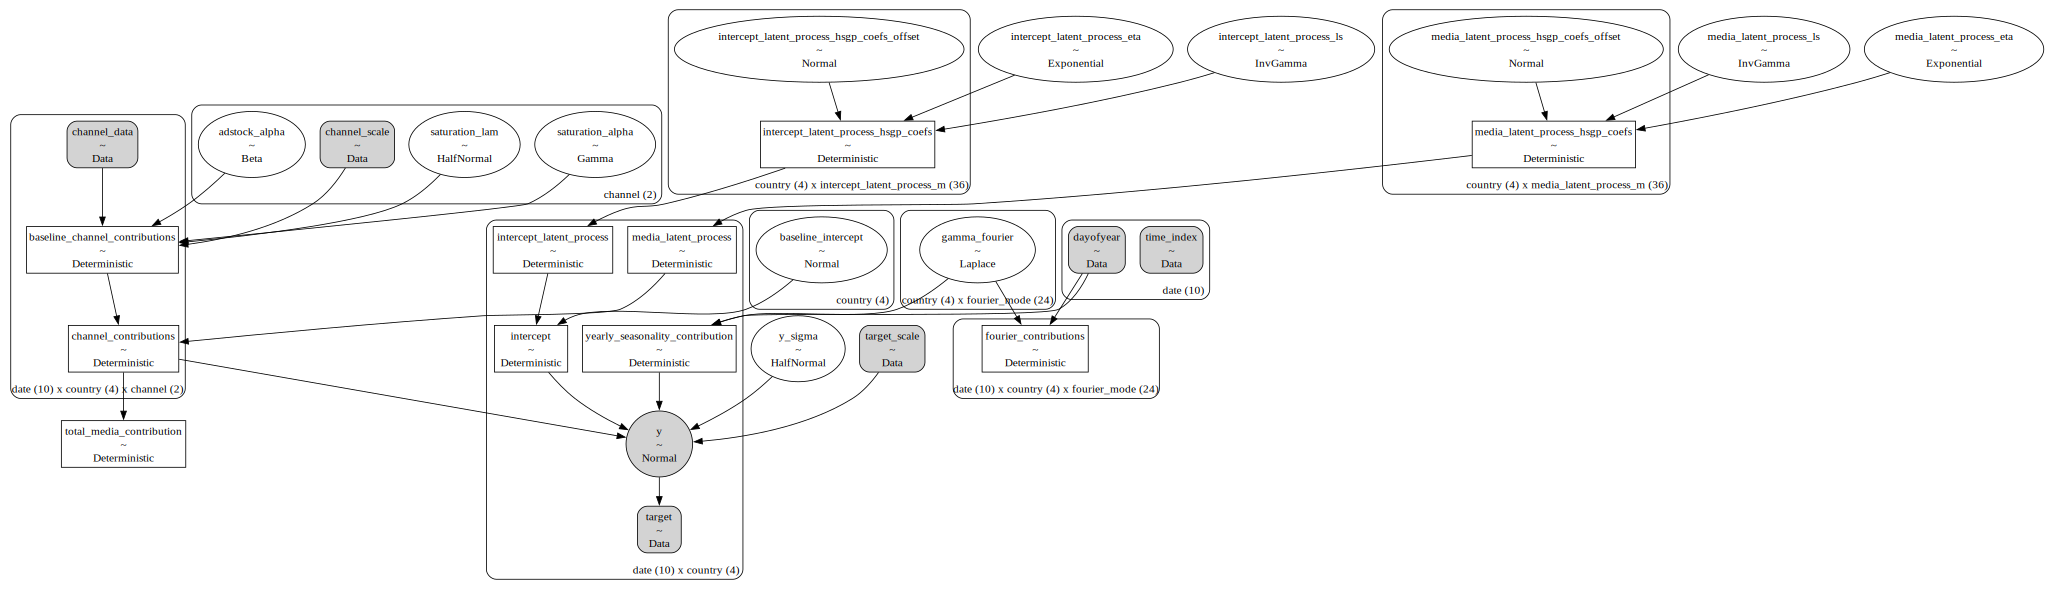

In [11]:
pm.model_to_graphviz(mmm.model)

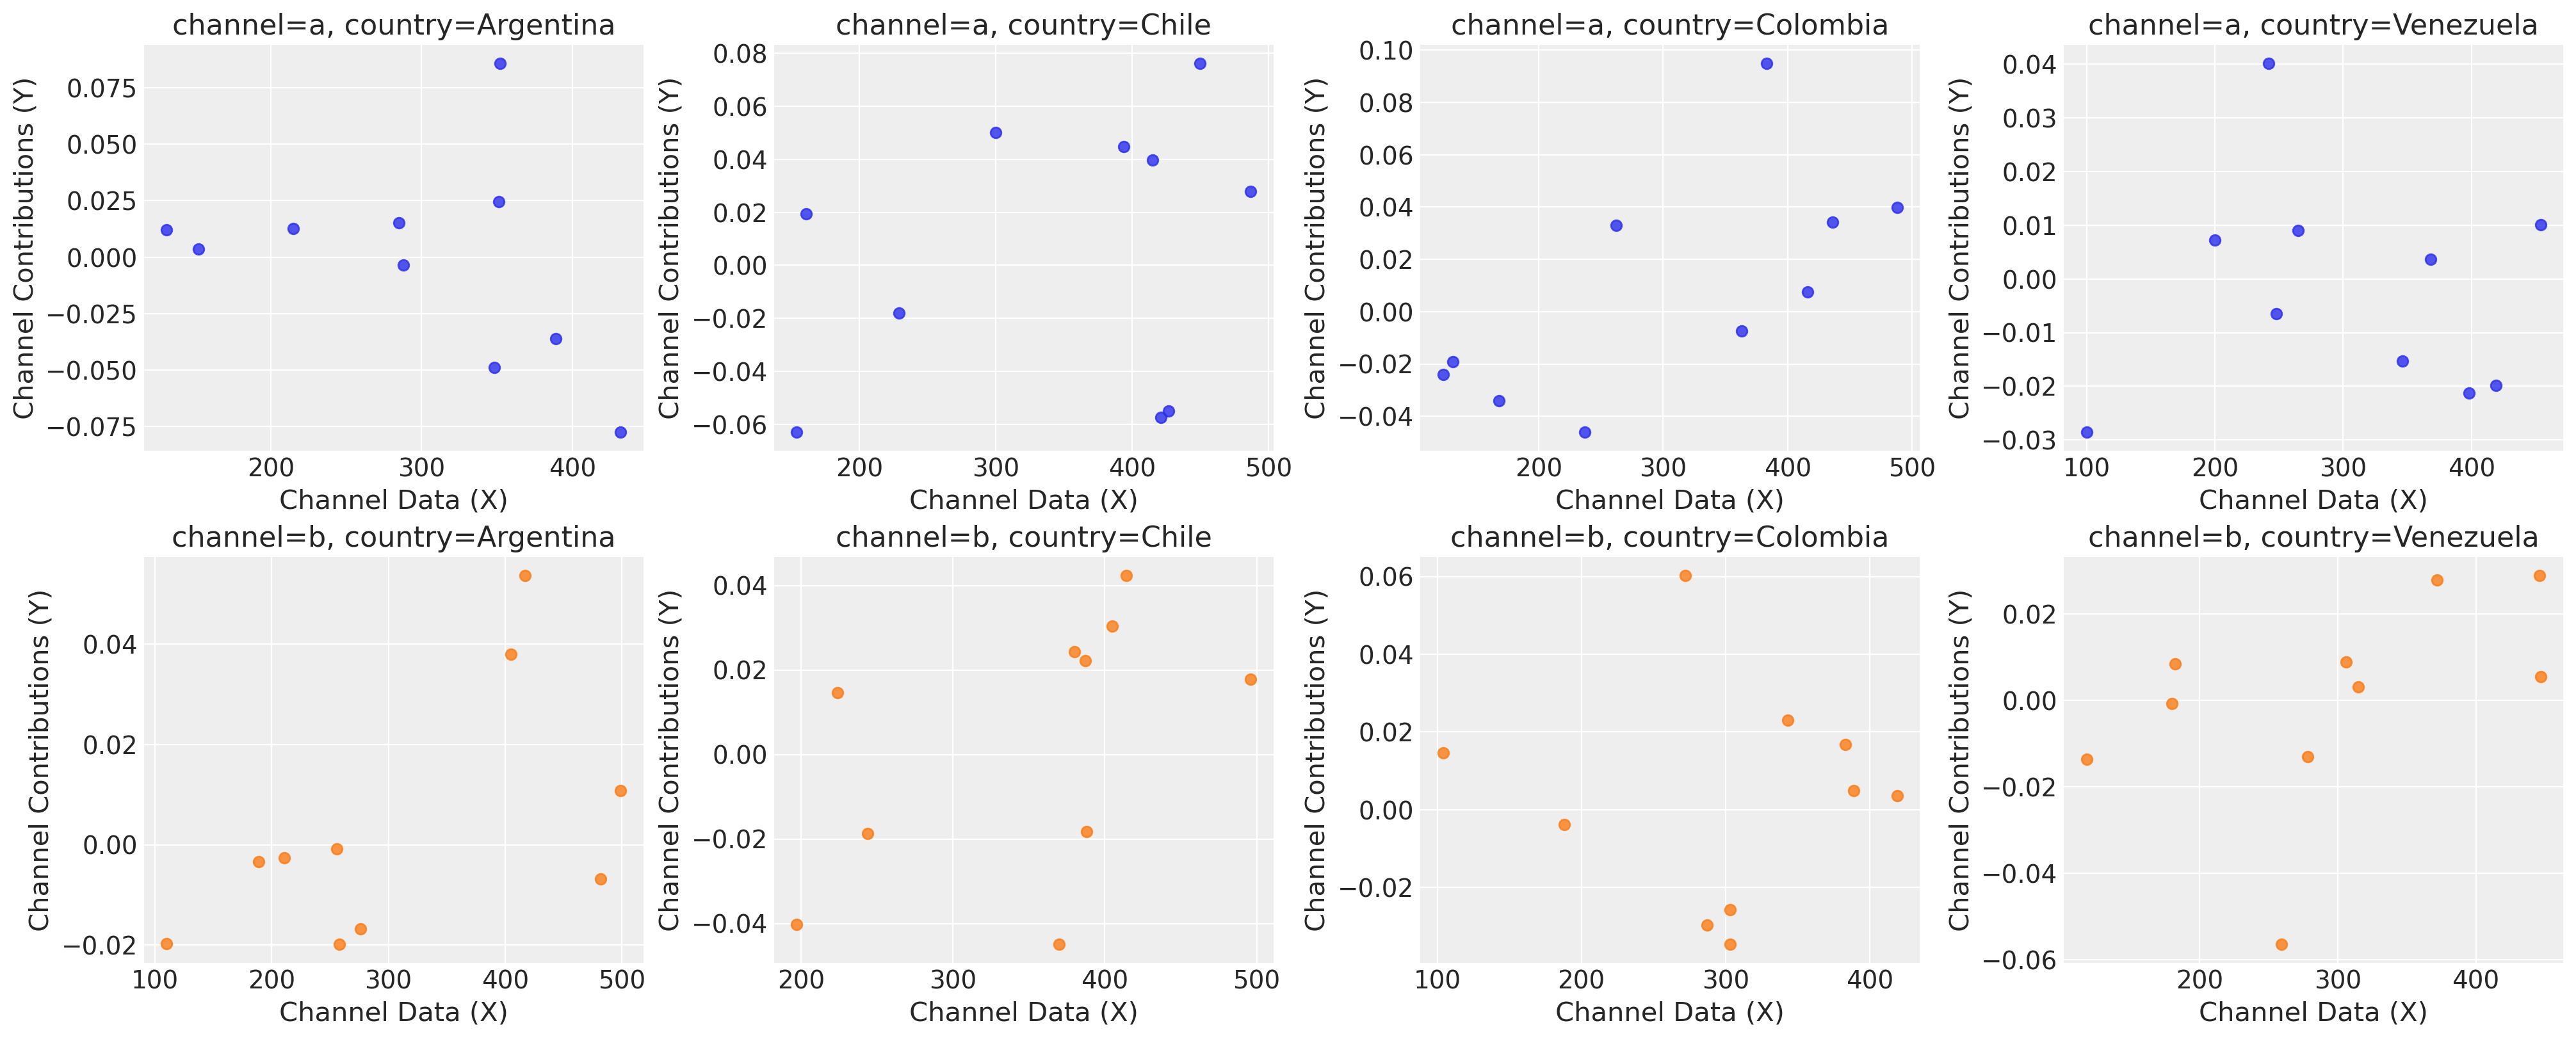

In [12]:
mmm.plot_saturation_curves_scatter();

In [15]:
mmm.sample_posterior_predictive(X=df.drop(columns="target"), y=None)

Sampling: [y]


Output()

<xarray.Dataset> Size: 1MB
Dimensions:  (date: 10, country: 4, sample: 4000)
Coordinates:
  * date     (date) datetime64[ns] 80B 2023-01-01 2023-01-02 ... 2023-01-10
  * country  (country) <U9 144B 'Argentina' 'Chile' 'Colombia' 'Venezuela'
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, country, sample) float64 1MB 951.2 945.2 ... 1.018e+03
Attributes:
    created_at:                 2025-01-25T18:21:55.158897+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.20.0

In [14]:
mmm.idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

In [15]:
mmm.idata.posterior[["saturation_alpha","saturation_lam"]]

<xarray.Dataset> Size: 136kB
Dimensions:           (chain: 4, draw: 1000, channel: 2)
Coordinates:
  * chain             (chain) int64 32B 0 1 2 3
  * draw              (draw) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * channel           (channel) <U1 8B 'a' 'b'
Data variables:
    saturation_alpha  (chain, draw, channel) float64 64kB 3.49 1.936 ... 1.299
    saturation_lam    (chain, draw, channel) float64 64kB 1.907 0.7678 ... 0.943
Attributes:
    created_at:                 2025-01-20T22:39:56.973120+00:00
    arviz_version:              0.20.0
    inference_library:          numpyro
    inference_library_version:  0.16.1
    sampling_time:              40.789322
    tuning_steps:               1000

In [16]:
mmm.saturation

MichaelisMentenSaturation(prefix='saturation', priors={'alpha': Prior("Gamma", mu=2, sigma=1, dims="channel"), 'lam': Prior("HalfNormal", sigma=1, dims="channel")})

In [17]:
mmm.saturation.function(
    x=3,
    lam=mmm.idata.posterior["saturation_lam"].values,
    alpha=mmm.idata.posterior["saturation_alpha"].values,
).eval().shape

(4, 1000, 2)

Sampling: []


Output()

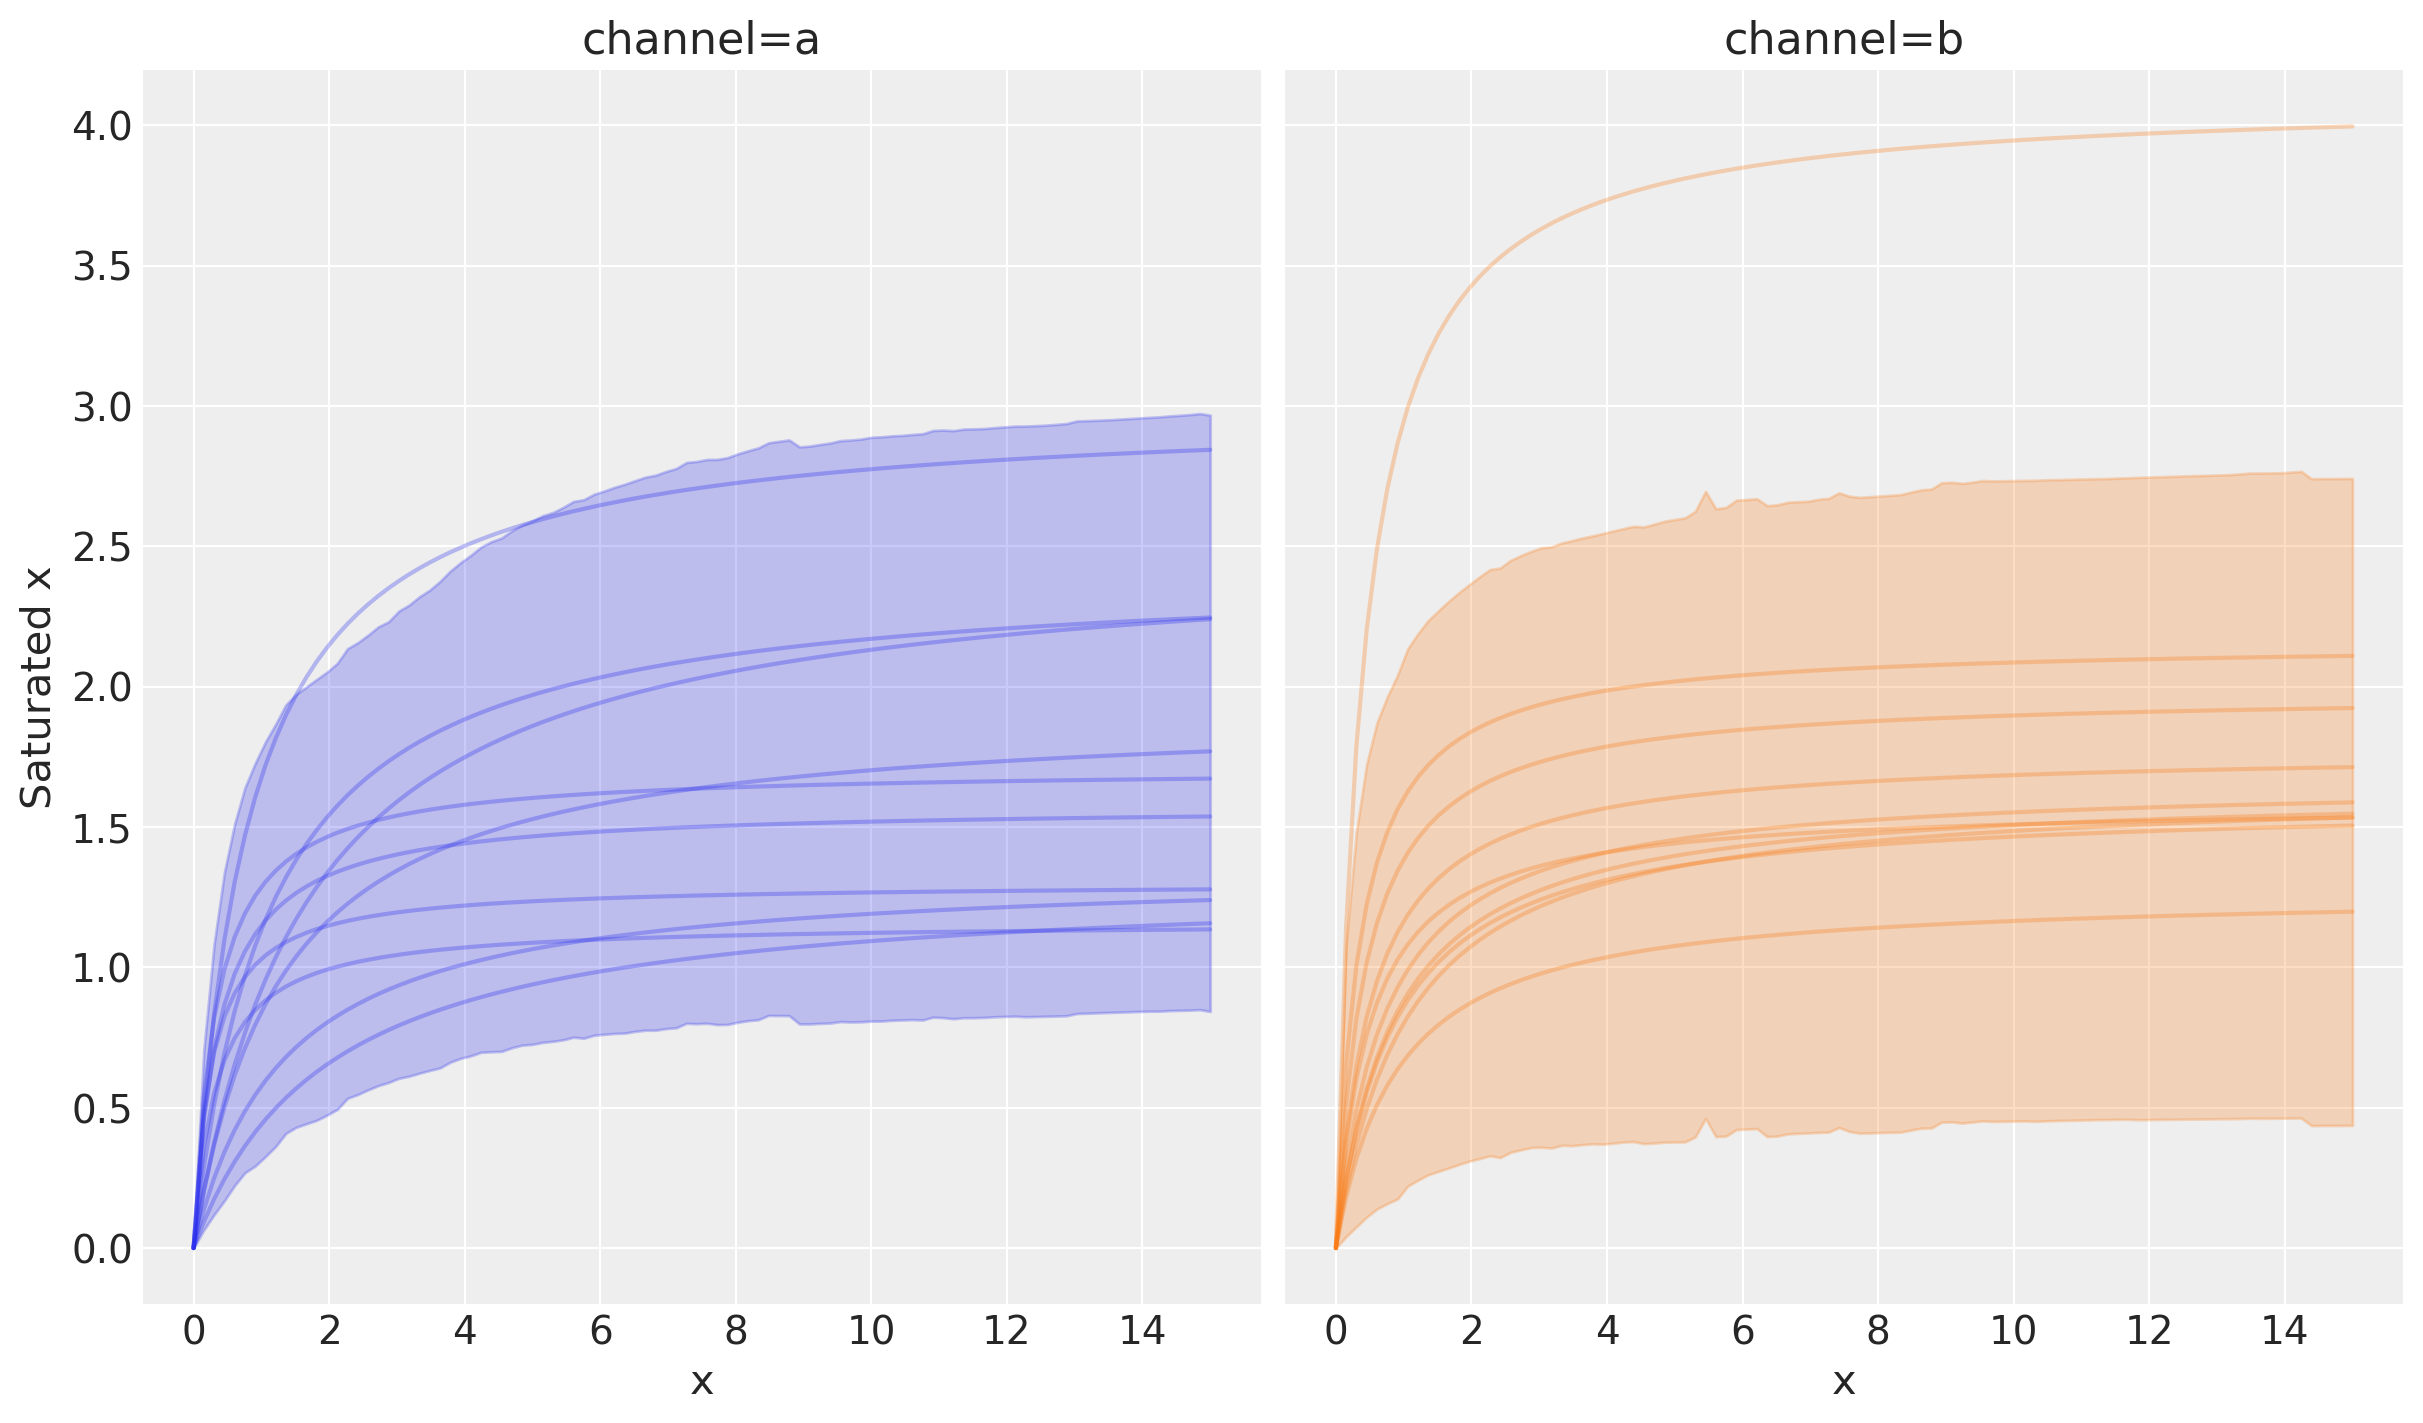

In [18]:
# mmm.saturation.plot_curve(curve=mmm.idata.posterior[["saturation_lam","saturation_beta"]]);

curve = mmm.saturation.sample_curve(
    mmm.idata.posterior[[var for var in mmm.idata.posterior.data_vars if var.startswith("saturation_")]], 
    max_value=15
)
_, axes = mmm.saturation.plot_curve(curve)
axes[0].set(
    ylabel="Saturated x",
    # title="Posterior Saturation Curve",
);

In [19]:
mmm = MMM(
    date_column="date",
    target_column="target",
    channel_columns=["a", "b"],
    # dims=("country",),
    adstock=GeometricAdstock(l_max=8),
    saturation=MichaelisMentenSaturation(),
)

# df.drop(columns="country", inplace=True)

In [20]:
mmm.fit(
    X=df.drop(columns=["country", "target"]), y=df.drop(columns=[*channels, "country"])
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, adstock_alpha, saturation_alpha, saturation_lam, y_sigma]
/opt/anaconda3/envs/pymc-marketing-dev/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/opt/anaconda3/envs/pymc-marketing-dev/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
There were 371 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

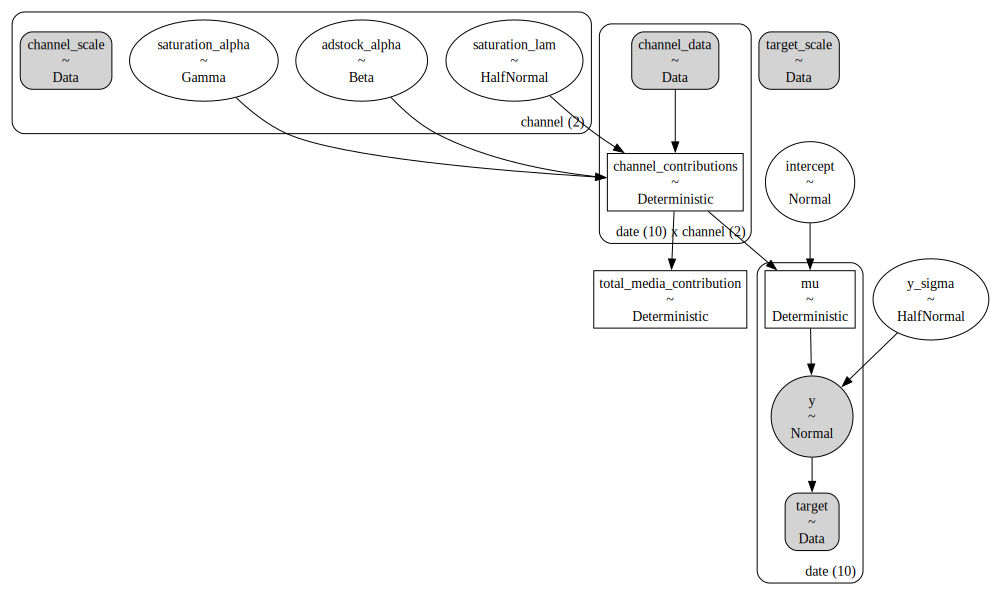

In [21]:
pm.model_to_graphviz(mmm.model)

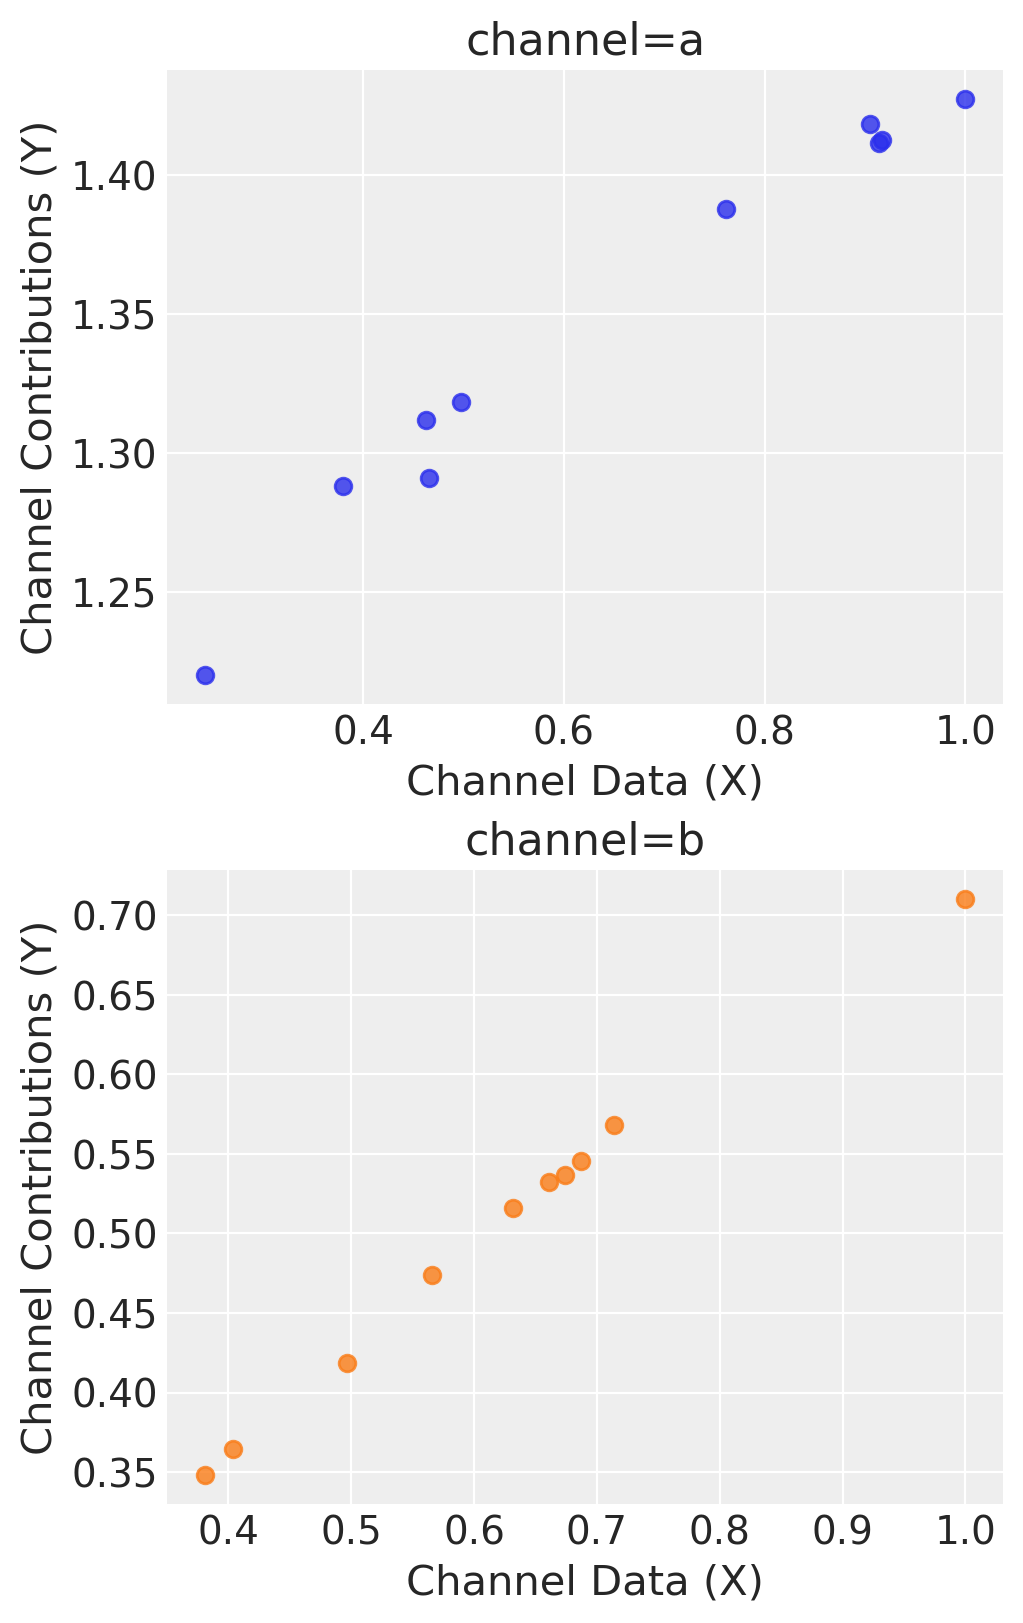

In [22]:
mmm.plot_saturation_curves_scatter();